In [1]:
setwd("/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/Experiments/1. Compartment Analysis/1.5. Cluster Distribution Analyses/1.5.2. ANOVA_ANCOVA/Input")
Output = ('/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/Experiments/1. Compartment Analysis/1.5. Cluster Distribution Analyses/1.5.2. ANOVA_ANCOVA/Output')
cur_date = "052021"

library(readxl)
library(factoextra)
library(missForest)
#library(plyr) #this must be loaded before tidyverse
library(tidyverse)
library(ggpubr)
library(janitor)
library(reshape2)
library(car) #package necessary to run anova and specify type III errors

#reading in files
subjectinfo <-  data.frame(read_excel("SubjectInfo_102920.xlsx", sheet = 2))
eigencytokines_NLF = read_csv("021821_NLF_eigencytokines.csv") %>%
    column_to_rownames(var = "X1")
eigencytokines_NELF = read_csv("021821_NELF_eigencytokines.csv") %>%
    column_to_rownames(var = "X1")
eigencytokines_Sputum = read_csv("021821_Sputum_eigencytokines.csv") %>%
    column_to_rownames(var = "X1")
eigencytokines_Serum = read_csv("021821_Serum_eigencytokines.csv") %>%
    column_to_rownames(var = "X1")

Loading required package: ggplot2

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Loading required package: randomForest

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


Loading required package: foreach

Loading required package: itertools

Loading required package: iterators

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.6     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate()    masks foreach::accumulate()
✖ dplyr::combine()       masks randomForest::combine()
✖ dplyr::filter()        masks stats::filter()
✖ dplyr::lag()           masks stats::lag()
✖ randomForest::margin() masks ggplot2::margin()
✖ purr

In [2]:
#first pseudo log2 transforming all values and then scaling all eigencytokine dfs
#normally you wouldn't do this, but was done to help meet more of the ANOVA assumptions
eigencytokines_NELF_scaled <- as.data.frame(scale(log2(eigencytokines_NELF + 1)))
eigencytokines_NLF_scaled <- as.data.frame(scale(log2(eigencytokines_NLF + 1)))
eigencytokines_Serum_scaled <- as.data.frame(scale(log2(eigencytokines_Serum + 1)))
eigencytokines_Sputum_scaled <- as.data.frame(scale(log2(eigencytokines_Sputum + 1)))

head(eigencytokines_NLF_scaled)

,ClusterA,ClusterB,ClusterC
,<dbl>,<dbl>,<dbl>
NS_1,-0.9339594,0.7610626,-0.1203324
NS_10,-0.5237683,1.1305985,0.6157292
NS_11,-0.0171691,0.6122665,0.6327026
NS_12,-0.9538211,0.1390103,0.9437728
NS_13,-1.4503422,0.9326770,0.4460119
NS_14,-1.8414450,0.8281043,0.5153413


In [3]:
#adding a col to designate smoking status 
eigen_NLF_scaled = eigencytokines_NLF_scaled %>%
    rownames_to_column("SubjectID") %>%
    inner_join(subjectinfo) %>%
    select(SubjectID, ClusterA, ClusterB, ClusterC, Group, Age)
eigen_NELF_scaled = eigencytokines_NELF_scaled %>%
    rownames_to_column("SubjectID") %>%
    inner_join(subjectinfo) %>%
    select(SubjectID, ClusterA, ClusterB, ClusterC, Group, Age)
eigen_Sputum_scaled = eigencytokines_Sputum_scaled %>%
    rownames_to_column("SubjectID") %>%
    inner_join(subjectinfo) %>%
    select(SubjectID, ClusterA, ClusterB, ClusterC, Group, Age)
eigen_Serum_scaled = eigencytokines_Serum_scaled %>%
    rownames_to_column("SubjectID") %>%
    inner_join(subjectinfo) %>%
    select(SubjectID, ClusterA, ClusterB, ClusterC, Group, Age)

head(eigen_NLF_scaled)

Joining, by = "SubjectID"

Joining, by = "SubjectID"

Joining, by = "SubjectID"

Joining, by = "SubjectID"



,SubjectID,ClusterA,ClusterB,ClusterC,Group,Age
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,NS_1,-0.9339594,0.7610626,-0.1203324,NS,28
2,NS_10,-0.5237683,1.1305985,0.6157292,NS,34
3,NS_11,-0.0171691,0.6122665,0.6327026,NS,24
4,NS_12,-0.9538211,0.1390103,0.9437728,NS,26
5,NS_13,-1.4503422,0.9326770,0.4460119,NS,39
6,NS_14,-1.8414450,0.8281043,0.5153413,NS,31


# Checking Assumptions

Linearity Assumption

In [4]:
NLF_assumptions_df = eigen_NLF_scaled[,1:4] %>%
    pivot_longer(-SubjectID, names_to = 'Cluster', values_to = 'Conc') %>%
    inner_join(subjectinfo) %>%
    select(SubjectID, Cluster, Conc, Group, Age) 
NELF_assumptions_df = eigen_NELF_scaled[,1:4] %>%
    pivot_longer(-SubjectID, names_to = 'Cluster', values_to = 'Conc') %>%
    inner_join(subjectinfo) %>%
    select(SubjectID, Cluster, Conc, Group, Age) 
Sputum_assumptions_df = eigen_Sputum_scaled[,1:4] %>%
    pivot_longer(-SubjectID, names_to = 'Cluster', values_to = 'Conc') %>%
    inner_join(subjectinfo) %>%
    select(SubjectID, Cluster, Conc, Group, Age) 
Serum_assumptions_df = eigen_Serum_scaled[,1:4] %>%
    pivot_longer(-SubjectID, names_to = 'Cluster', values_to = 'Conc') %>%
    inner_join(subjectinfo) %>%
    select(SubjectID, Cluster, Conc, Group, Age) 

Joining, by = "SubjectID"

Joining, by = "SubjectID"

Joining, by = "SubjectID"

Joining, by = "SubjectID"



In [5]:
add_compartment = function(dataframe, compartment_name){
    #"""
    #Takes the dataframes already made from above and adds a column specifying the compartment.

    #:param: compartment dataframe and compartment name
    #:output: a 22x3 matrix containing mean, sd, and compartment for each cytokine. 
    #"""
    Compartment = rep(compartment_name, times = length(dataframe$Cluster))
    combined_df = cbind(dataframe,Compartment)
    return(combined_df)
}
NLF_assumptions_df = add_compartment(NLF_assumptions_df,'NLF')
NELF_assumptions_df = add_compartment(NELF_assumptions_df, 'NELF')
Sputum_assumptions_df = add_compartment(Sputum_assumptions_df, 'Sputum')
Serum_assumptions_df = add_compartment(Serum_assumptions_df, 'Serum')

#combining into a single df
assumptions_df = rbind(NLF_assumptions_df, NELF_assumptions_df, Sputum_assumptions_df, Serum_assumptions_df)
head(assumptions_df)

,SubjectID,Cluster,Conc,Group,Age,Compartment
,<chr>,<chr>,<dbl>,<chr>,<dbl>,<fct>
1,NS_1,ClusterA,-0.9339594,NS,28,NLF
2,NS_1,ClusterB,0.7610626,NS,28,NLF
3,NS_1,ClusterC,-0.1203324,NS,28,NLF
4,NS_10,ClusterA,-0.5237683,NS,34,NLF
5,NS_10,ClusterB,1.1305985,NS,34,NLF
6,NS_10,ClusterC,0.6157292,NS,34,NLF


`geom_smooth()` using formula 'y ~ x'



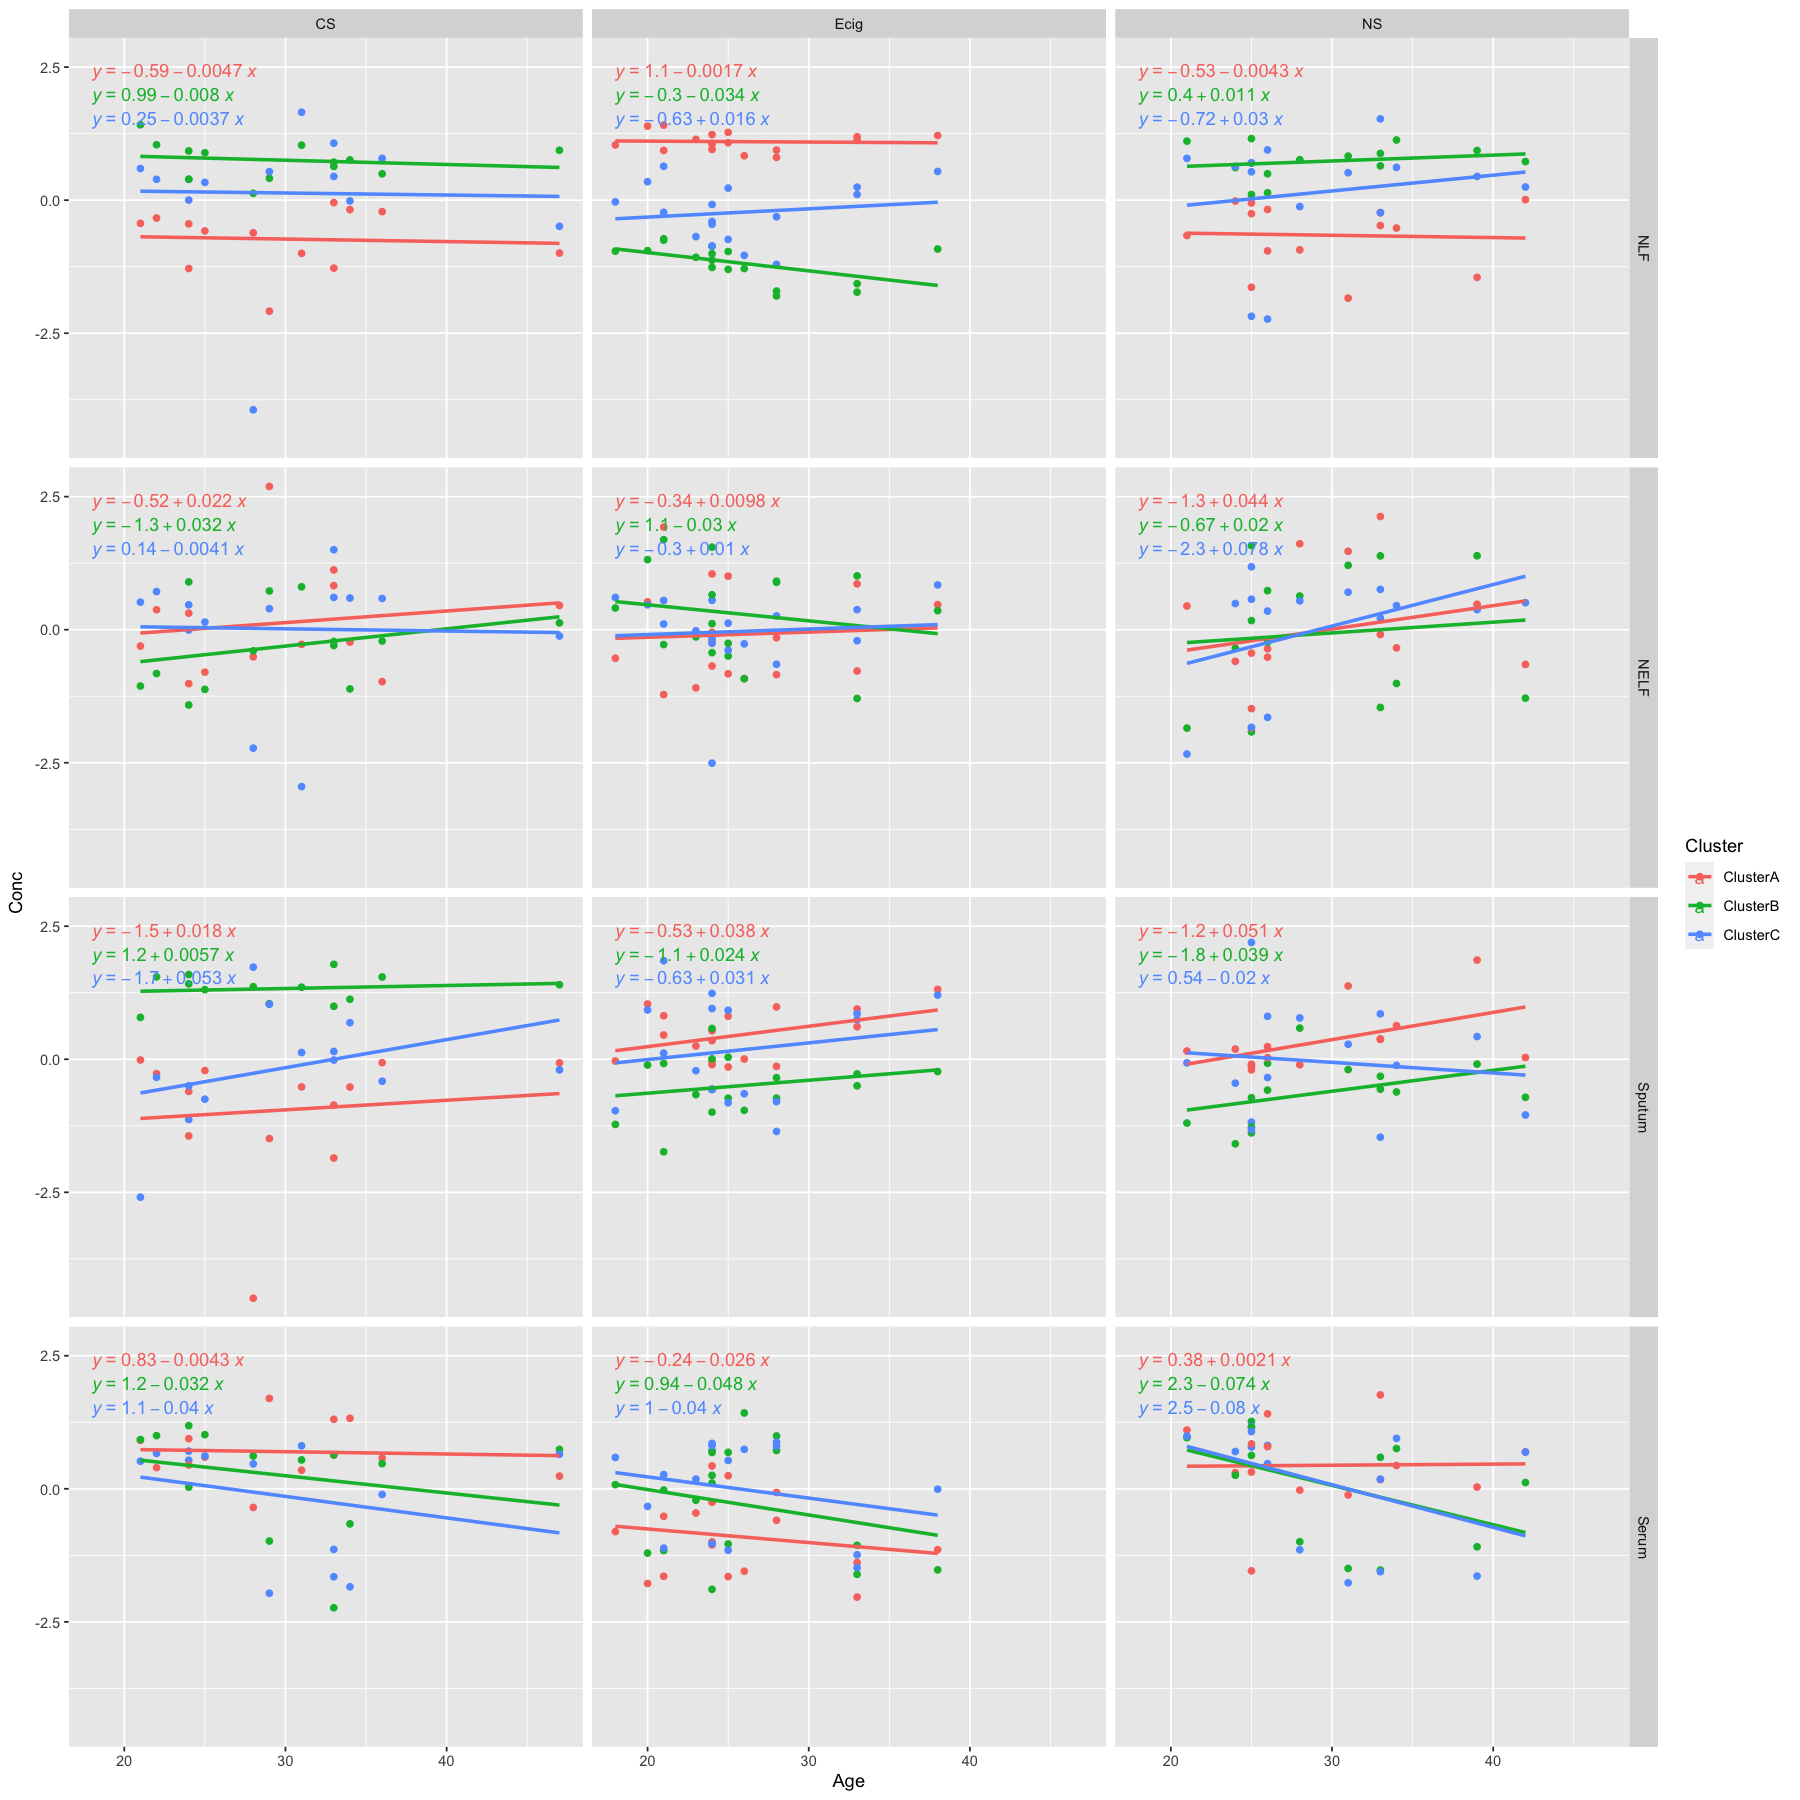

In [6]:
#this is for ancova first
#scatter plot b/w covariate(age) & outcome variable (clustered cytokine concentration)
options(repr.plot.width=15, repr.plot.height=15) #changing size
ggplot(data = assumptions_df, aes(x = Age, y = Conc, color = Cluster, group = Cluster)) + 
  geom_point() + 
  geom_smooth(method = 'lm', se = FALSE) + 
  #geom_text(aes(x = Age, y = Conc, label = summary(lm(Conc ~ Age, assumptions_df))$r.squared), parse = TRUE) + 
  stat_regline_equation() + 
  facet_grid(Compartment~Group)

In [7]:
clusters = unique(assumptions_df$Cluster)
smoking_groups = unique(assumptions_df$Group)

#need r squared values for these
lm_eqn <- function(df){
    for (i in 1:length(clusters)){
        for (j in 1:length(smoking_groups)){
            m <- lm(Conc ~ Age, df %>%
                   filter(Cluster == clusters[i], Group == smoking_groups[j]));
            eq <- substitute(italic(y) == a + b %.% italic(x)*","~~italic(r)^2~"="~r2, 
                 list(a = format(unname(coef(m)[1]), digits = 2),
                      b = format(unname(coef(m)[2]), digits = 2),
                     r2 = format(summary(m)$r.squared, digits = 3)))
            #return(as.character(as.expression(eq)))
            print(c(clusters[i], smoking_groups[j],as.character(as.expression(eq))))
        }

    }
}

#ancova (calling fn)
lm_eqn(NLF_assumptions_df)
lm_eqn(NELF_assumptions_df)
lm_eqn(Sputum_assumptions_df)
lm_eqn(Serum_assumptions_df)

[1] "ClusterA"                                                                                       
[2] "NS"                                                                                             
[3] "italic(y) == \"-0.53\" + \"-0.0043\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.00181\""
[1] "ClusterA"                                                                                       
[2] "CS"                                                                                             
[3] "italic(y) == \"-0.59\" + \"-0.0047\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.00342\""
[1] "ClusterA"                                                                                     
[2] "Ecig"                                                                                         
[3] "italic(y) == \"1.1\" + \"-0.0017\" %.% italic(x) * \",\" ~ ~italic(r)^2 ~ \"=\" ~ \"0.00252\""
[1] "ClusterB"                                                                          

The r squared values indicate that the linearity assumption isn't met. 

<b> Homogeneity of Regression Slopes: checks that there's no significant interaction between the covariate and the grouping variable. </b>

In [8]:
library(rstatix)


Attaching package: ‘rstatix’


The following object is masked from ‘package:janitor’:

    make_clean_names


The following object is masked from ‘package:stats’:

    filter




In [9]:
homogeneity_test_ancova = function(df, cluster){
    test = df %>%
        filter(Cluster == cluster) %>%
        anova_test(Conc~Group*Age)
    return(test[3,]) #just need the last row that shows this interaction
}
homogeneity_test_ancova(NLF_assumptions_df, 'ClusterA')
homogeneity_test_ancova(NLF_assumptions_df, 'ClusterB')
homogeneity_test_ancova(NLF_assumptions_df, 'ClusterC')
homogeneity_test_ancova(NELF_assumptions_df, 'ClusterA')
homogeneity_test_ancova(NELF_assumptions_df, 'ClusterB')
homogeneity_test_ancova(NELF_assumptions_df, 'ClusterC')
homogeneity_test_ancova(Sputum_assumptions_df, 'ClusterA')
homogeneity_test_ancova(Sputum_assumptions_df, 'ClusterB')
homogeneity_test_ancova(Sputum_assumptions_df, 'ClusterC')
homogeneity_test_ancova(Serum_assumptions_df, 'ClusterA')
homogeneity_test_ancova(Serum_assumptions_df, 'ClusterB')
homogeneity_test_ancova(Serum_assumptions_df, 'ClusterC')

Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
3,Group:Age,2,38,0.005,0.995,,0.000265


Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
3,Group:Age,2,38,2.184,0.127,,0.103


Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
3,Group:Age,2,38,0.142,0.868,,0.007


Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
3,Group:Age,2,38,0.128,0.881,,0.007


Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
3,Group:Age,2,38,0.507,0.606,,0.026


Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
3,Group:Age,2,38,0.931,0.403,,0.047


Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
3,Group:Age,2,38,0.242,0.786,,0.013


Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
3,Group:Age,2,38,0.626,0.54,,0.032


Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
3,Group:Age,2,38,0.696,0.505,,0.035


Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
3,Group:Age,2,38,0.179,0.837,,0.009


Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
3,Group:Age,2,38,0.242,0.786,,0.013


Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
3,Group:Age,2,38,0.264,0.769,,0.014


Since none of the pvalues < 0.05, this assumption is met. 

<b>Normality of residuals</b>

In [10]:
#this is for ancova
residual_normality_test = function(df, cluster){
    model = lm(Conc~Age+Group, data = df %>%
        filter(Cluster == cluster))
    model.metrics <- augment(model) 
    shapiro_wilk_test = shapiro_test(model.metrics$.resid)
    return(shapiro_wilk_test)
}
residual_normality_test(NLF_assumptions_df, 'ClusterA')
residual_normality_test(NLF_assumptions_df, 'ClusterB') #residuals aren't normal
residual_normality_test(NLF_assumptions_df, 'ClusterC') #residuals aren't normal
residual_normality_test(NELF_assumptions_df, 'ClusterA') #residuals aren't normal
residual_normality_test(NELF_assumptions_df, 'ClusterB') #residuals aren't normal
residual_normality_test(NELF_assumptions_df, 'ClusterC')
residual_normality_test(Sputum_assumptions_df, 'ClusterA')
residual_normality_test(Sputum_assumptions_df, 'ClusterB') #residuals aren't normal
residual_normality_test(Sputum_assumptions_df, 'ClusterC') #residuals aren't normal
residual_normality_test(Serum_assumptions_df, 'ClusterA') #residuals aren't normal
residual_normality_test(Serum_assumptions_df, 'ClusterB')
residual_normality_test(Serum_assumptions_df, 'ClusterC') #residuals aren't normal

variable,statistic,p.value
<chr>,<dbl>,<dbl>
model.metrics$.resid,0.9346235,0.0151743


variable,statistic,p.value
<chr>,<dbl>,<dbl>
model.metrics$.resid,0.9530197,0.07130481


variable,statistic,p.value
<chr>,<dbl>,<dbl>
model.metrics$.resid,0.8057233,3.899186e-06


variable,statistic,p.value
<chr>,<dbl>,<dbl>
model.metrics$.resid,0.9462246,0.03988202


variable,statistic,p.value
<chr>,<dbl>,<dbl>
model.metrics$.resid,0.9678847,0.2542954


variable,statistic,p.value
<chr>,<dbl>,<dbl>
model.metrics$.resid,0.8161401,6.6836e-06


variable,statistic,p.value
<chr>,<dbl>,<dbl>
model.metrics$.resid,0.8305321,1.448031e-05


variable,statistic,p.value
<chr>,<dbl>,<dbl>
model.metrics$.resid,0.9824797,0.7328688


variable,statistic,p.value
<chr>,<dbl>,<dbl>
model.metrics$.resid,0.9899948,0.9646423


variable,statistic,p.value
<chr>,<dbl>,<dbl>
model.metrics$.resid,0.9791836,0.6012837


variable,statistic,p.value
<chr>,<dbl>,<dbl>
model.metrics$.resid,0.9645349,0.1918712


variable,statistic,p.value
<chr>,<dbl>,<dbl>
model.metrics$.resid,0.8991793,0.001026893


This assumption isn't met for most clusters. 

<b> Homogeneity of Variances: ANCOVA/ ANOVA assumes the variance of residuals is equal for all groups </b>

In [11]:
residual_variance_test_anova = function(df, cluster){
    model = lm(Conc~Group, data = df %>%
        filter(Cluster == cluster))
    model.metrics <- augment(model) 
    levene_test = leveneTest(`.resid`~Group, data = model.metrics)
    return(levene_test)
}
#anova
residual_variance_test_anova(NLF_assumptions_df, 'ClusterA')
residual_variance_test_anova(NLF_assumptions_df, 'ClusterB') 
residual_variance_test_anova(NLF_assumptions_df, 'ClusterC') 
residual_variance_test_anova(NELF_assumptions_df, 'ClusterA') 
residual_variance_test_anova(NELF_assumptions_df, 'ClusterB') 
residual_variance_test_anova(NELF_assumptions_df, 'ClusterC')
residual_variance_test_anova(Sputum_assumptions_df, 'ClusterA')
residual_variance_test_anova(Sputum_assumptions_df, 'ClusterB') 
residual_variance_test_anova(Sputum_assumptions_df, 'ClusterC') 
residual_variance_test_anova(Serum_assumptions_df, 'ClusterA') 
residual_variance_test_anova(Serum_assumptions_df, 'ClusterB')
residual_variance_test_anova(Serum_assumptions_df, 'ClusterC') 

Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,5.464431,0.007873878
,41,NA,NA


Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,0.09344363,0.9109828
,41,NA,NA


Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,0.3587622,0.7007115
,41,NA,NA


Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,0.07628561,0.9266827
,41,NA,NA


Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,3.477382,0.04027339
,41,NA,NA


Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,0.2807684,0.7566435
,41,NA,NA


Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,1.302335,0.2829061
,41,NA,NA


Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,2.473538,0.0967793
,41,NA,NA


Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,0.1970282,0.8219404
,41,NA,NA


Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,0.8611584,0.4301756
,41,NA,NA


Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,0.390116,0.6794644
,41,NA,NA


Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,0.05312184,0.9483296
,41,NA,NA


In [12]:
residual_variance_test_ancova = function(df, cluster){
    model = lm(Conc~Age+Group, data = df %>%
        filter(Cluster == cluster))
    model.metrics <- augment(model) 
    levene_test = leveneTest(`.resid`~Group, data = model.metrics)
    return(levene_test)
}
#ancova
residual_variance_test_ancova(NLF_assumptions_df, 'ClusterA')
residual_variance_test_ancova(NLF_assumptions_df, 'ClusterB') 
residual_variance_test_ancova(NLF_assumptions_df, 'ClusterC') 
residual_variance_test_ancova(NELF_assumptions_df, 'ClusterA') 
residual_variance_test_ancova(NELF_assumptions_df, 'ClusterB') 
residual_variance_test_ancova(NELF_assumptions_df, 'ClusterC')
residual_variance_test_ancova(Sputum_assumptions_df, 'ClusterA')
residual_variance_test_ancova(Sputum_assumptions_df, 'ClusterB') 
residual_variance_test_ancova(Sputum_assumptions_df, 'ClusterC') 
residual_variance_test_ancova(Serum_assumptions_df, 'ClusterA') 
residual_variance_test_ancova(Serum_assumptions_df, 'ClusterB')
residual_variance_test_ancova(Serum_assumptions_df, 'ClusterC') 

Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,5.216439,0.00958588
,41,NA,NA


Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,0.002060255,0.997942
,41,NA,NA


Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,0.4613319,0.633676
,41,NA,NA


Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,0.08455784,0.9190783
,41,NA,NA


Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,3.656438,0.03457639
,41,NA,NA


Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,0.3822103,0.6847572
,41,NA,NA


Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,2.035468,0.1436115
,41,NA,NA


Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,1.359694,0.2680714
,41,NA,NA


Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,0.213174,0.8089054
,41,NA,NA


Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,0.7923186,0.4596038
,41,NA,NA


Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,0.3098555,0.7352556
,41,NA,NA


Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,0.007885225,0.9921473
,41,NA,NA


A few were significant  (p < 0.05) so this assumption isn't met.

# One-way ANOVA

Even though most of the assumptions tested above aren't we'll still proceed with running ANOVA/ANCOVA tests.

In [13]:
#need to make everything into a factor
eigen_NLF_scaled$Group = factor(eigen_NLF_scaled$Group)
eigen_NELF_scaled$Group = factor(eigen_NELF_scaled$Group)
eigen_Sputum_scaled$Group = factor(eigen_Sputum_scaled$Group)
eigen_Serum_scaled$Group = factor(eigen_Serum_scaled$Group)

In [14]:
#now I can run the anova comparing each group to one another within each cluster
#contrasts show what compartments are being compared in anova
#these comparisons aren't what we want so I changed them in the function below
contrasts(eigen_NLF_scaled$Group)

,Ecig,NS
CS,0,0
Ecig,1,0
NS,0,1


                 Table of Contrasts
>                   NS    | CS  |  Ecig  |  Sum
>     Contrast 1 |  -1    |  1  |   0    |   0
>     Contrast 2 |  -1    |  0  |   1    |   0

> - Contrast 1: compares NS to CS
> - Contrast 2: compares NS to Ecig

In [15]:
get_anova1 = function(scaled_df){
    contrasts(scaled_df$Group) = cbind(c(-1,1,0),c(-1,0,1)) #meaning is specified above
    anova = aov(ClusterA~Group, data = scaled_df)
    return(anova)
}
get_anova2 = function(scaled_df){
    contrasts(scaled_df$Group) = cbind(c(-1,1,0),c(-1,0,1)) #meaning is specified above
    anova = aov(ClusterB~Group, data = scaled_df)
    return(anova)
}

get_anova3 = function(scaled_df){
    contrasts(scaled_df$Group) = cbind(c(-1,1,0),c(-1,0,1)) #meaning is specified above
    anova = aov(ClusterC~Group, data = scaled_df)
    return(anova)
}


#calling fn
NLF_ClusterA_anova = get_anova1(eigen_NLF_scaled)
NLF_ClusterB_anova = get_anova2(eigen_NLF_scaled)
NLF_ClusterC_anova = get_anova3(eigen_NLF_scaled)
NELF_ClusterA_anova = get_anova1(eigen_NELF_scaled)
NELF_ClusterB_anova = get_anova2(eigen_NELF_scaled)
NELF_ClusterC_anova = get_anova3(eigen_NELF_scaled)
Sputum_ClusterA_anova = get_anova1(eigen_Sputum_scaled)
Sputum_ClusterB_anova = get_anova2(eigen_Sputum_scaled)
Sputum_ClusterC_anova = get_anova3(eigen_Sputum_scaled)
Serum_ClusterA_anova = get_anova1(eigen_Serum_scaled)
Serum_ClusterB_anova = get_anova2(eigen_Serum_scaled)
Serum_ClusterC_anova = get_anova3(eigen_Serum_scaled)

# ANCOVA

In [16]:
#controlling for age
get_ancova_age1 = function(scaled_df){
    contrasts(scaled_df$Group) = cbind(c(-1,1,0),c(-1,0,1))#meaning is explained above
    ancova = aov(ClusterA~Age+Group, data = scaled_df)
    return(ancova)
}
get_ancova_age2 = function(scaled_df){
    contrasts(scaled_df$Group) = cbind(c(-1,1,0),c(-1,0,1)) #meaning is explained above
    ancova = aov(ClusterB~Age+Group, data = scaled_df)
    return(ancova)
}
get_ancova_age3 = function(scaled_df){
    contrasts(scaled_df$Group) = cbind(c(-1,1,0),c(-1,0,1)) #meaning is explained above
    ancova = aov(ClusterC~Age+Group, data = scaled_df)
    return(ancova)
}

#calling fn
NLF_ClusterA_ancova_age = get_ancova_age1(eigen_NLF_scaled)
NLF_ClusterB_ancova_age = get_ancova_age2(eigen_NLF_scaled)
NLF_ClusterC_ancova_age = get_ancova_age3(eigen_NLF_scaled)
NELF_ClusterA_ancova_age = get_ancova_age1(eigen_NELF_scaled)
NELF_ClusterB_ancova_age = get_ancova_age2(eigen_NELF_scaled)
NELF_ClusterC_ancova_age = get_ancova_age3(eigen_NELF_scaled)
Sputum_ClusterA_ancova_age = get_ancova_age1(eigen_Sputum_scaled)
Sputum_ClusterB_ancova_age = get_ancova_age2(eigen_Sputum_scaled)
Sputum_ClusterC_ancova_age = get_ancova_age3(eigen_Sputum_scaled)
Serum_ClusterA_ancova_age = get_ancova_age1(eigen_Serum_scaled)
Serum_ClusterB_ancova_age = get_ancova_age2(eigen_Serum_scaled)
Serum_ClusterC_ancova_age = get_ancova_age3(eigen_Serum_scaled)

# ANOVA/ANCOVA Tables

In [17]:
extract_values = function(anova_results){
    #extracting f and p values from the anova to be put into a table
    #cluster_summary = summary(anova_results)[[1]][1, 2:5] #f value, pvalue
    anova_type3 = Anova(anova_results, type = 'III')
    cluster_summary = anova_type3[2,3:4]
    f_value = cluster_summary$`F value`
    p_value = cluster_summary$`Pr(>F)`
    
    cluster_anova_values = c(f_value,p_value)
    return(cluster_anova_values)
}

#anova
NLF_ClusterA_anova_values = extract_values(NLF_ClusterA_anova)
NLF_ClusterB_anova_values = extract_values(NLF_ClusterB_anova)
NLF_ClusterC_anova_values = extract_values(NLF_ClusterC_anova)
NELF_ClusterA_anova_values = extract_values(NELF_ClusterA_anova)
NELF_ClusterB_anova_values = extract_values(NELF_ClusterB_anova)
NELF_ClusterC_anova_values = extract_values(NELF_ClusterC_anova)
Sputum_ClusterA_anova_values = extract_values(Sputum_ClusterA_anova)
Sputum_ClusterB_anova_values = extract_values(Sputum_ClusterB_anova)
Sputum_ClusterC_anova_values = extract_values(Sputum_ClusterC_anova)
Serum_ClusterA_anova_values = extract_values(Serum_ClusterA_anova)
Serum_ClusterB_anova_values = extract_values(Serum_ClusterB_anova)
Serum_ClusterC_anova_values = extract_values(Serum_ClusterC_anova)

In [18]:
extract_values_ancova = function(anova_results){
    #extracting f and p values from the anova to be put into a table
    #cluster_summary = summary(anova_results)[[1]][1, 2:5] #f value, pvalue
    anova_type3 = Anova(anova_results, type = 'III')
    cluster_summary = anova_type3[3,3:4]
    f_value = cluster_summary$`F value`
    p_value = cluster_summary$`Pr(>F)`
    
    cluster_anova_values = c(f_value,p_value)
    return(cluster_anova_values)
}
#ancova
NLF_ClusterA_ancova_age_values = extract_values_ancova(NLF_ClusterA_ancova_age)
NLF_ClusterB_ancova_age_values = extract_values_ancova(NLF_ClusterB_ancova_age)
NLF_ClusterC_ancova_age_values = extract_values_ancova(NLF_ClusterC_ancova_age)
NELF_ClusterA_ancova_age_values = extract_values_ancova(NELF_ClusterA_ancova_age)
NELF_ClusterB_ancova_age_values = extract_values_ancova(NELF_ClusterB_ancova_age)
NELF_ClusterC_ancova_age_values = extract_values_ancova(NELF_ClusterC_ancova_age)
Sputum_ClusterA_ancova_age_values = extract_values_ancova(Sputum_ClusterA_ancova_age)
Sputum_ClusterB_ancova_age_values = extract_values_ancova(Sputum_ClusterB_ancova_age)
Sputum_ClusterC_ancova_age_values = extract_values_ancova(Sputum_ClusterC_ancova_age)
Serum_ClusterA_ancova_age_values = extract_values_ancova(Serum_ClusterA_ancova_age)
Serum_ClusterB_ancova_age_values = extract_values_ancova(Serum_ClusterB_ancova_age)
Serum_ClusterC_ancova_age_values = extract_values_ancova(Serum_ClusterC_ancova_age)

In [19]:
table_summary = function(NLF_ClusterA, NLF_ClusterB, NLF_ClusterC, NELF_ClusterA, NELF_ClusterB, 
                         NELF_ClusterC, Sputum_ClusterA, Sputum_ClusterB, Sputum_ClusterC, Serum_ClusterA, 
                         Serum_ClusterB, Serum_ClusterC){
    #comment
    table_initial = rbind(NLF_ClusterA, NLF_ClusterB, NLF_ClusterC, NELF_ClusterA, NELF_ClusterB, 
                         NELF_ClusterC, Sputum_ClusterA, Sputum_ClusterB, Sputum_ClusterC, Serum_ClusterA, 
                         Serum_ClusterB, Serum_ClusterC)
    
    colnames(table_initial) = c('F Value','p value')
    return(table_initial)
}

#calling function
anova_table = table_summary(NLF_ClusterA_anova_values, NLF_ClusterB_anova_values, NLF_ClusterC_anova_values, 
                            NELF_ClusterA_anova_values, NELF_ClusterB_anova_values, NELF_ClusterC_anova_values, 
                            Sputum_ClusterA_anova_values, Sputum_ClusterB_anova_values, Sputum_ClusterC_anova_values, 
                            Serum_ClusterA_anova_values, Serum_ClusterB_anova_values, Serum_ClusterC_anova_values)
ancova_age_table = table_summary(NLF_ClusterA_ancova_age_values, NLF_ClusterB_ancova_age_values, 
                                 NLF_ClusterC_ancova_age_values, NELF_ClusterA_ancova_age_values, 
                                 NELF_ClusterB_ancova_age_values, NELF_ClusterC_ancova_age_values, 
                                 Sputum_ClusterA_ancova_age_values, Sputum_ClusterB_ancova_age_values, 
                                 Sputum_ClusterC_ancova_age_values, Serum_ClusterA_ancova_age_values, 
                                 Serum_ClusterB_ancova_age_values, Serum_ClusterC_ancova_age_values)
allresults = cbind(anova_table, ancova_age_table)

In [20]:
col_names = c('F Value ANOVA','p value', 'P Adj', 'F Value ANCOVA','p value', 'P Adj')
final_table_summary = function(table, names_vector){
    #going back to calculate padj values
    padj = apply(cbind(table[,2],table[,4]), 2, p.adjust, method = "fdr") #the 2 applies function down the col
    
    #inserting these back into the OG df to export all values
    final_table = cbind(table[,1], table[,2], padj[,1], table[,3], table[,4],padj[,2])
    colnames(final_table) = names_vector
    return(final_table)
}
#calling fn
clustered_anova_ancova = final_table_summary(allresults, col_names)
clustered_anova_ancova

,F Value ANOVA,p value,P Adj,F Value ANCOVA,p value,P Adj
NLF_ClusterA,72.51468509,3.432796e-14,2.059678e-13,62.76106384,4.614011e-13,1.845604e-12
NLF_ClusterB,168.17761663,1.732552e-20,2.079063e-19,157.98521729,1.030199e-19,1.236239e-18
NLF_ClusterC,0.73454925,4.859277e-01,7.288916e-01,0.49170560,6.152304e-01,7.932618e-01
NELF_ClusterA,0.16686923,8.468821e-01,9.238714e-01,0.06418137,9.379313e-01,9.880817e-01
NELF_ClusterB,1.47912986,2.397392e-01,4.794783e-01,1.53527232,2.278204e-01,3.905492e-01
NELF_ClusterC,0.01492165,9.851945e-01,9.851945e-01,0.01199354,9.880817e-01,9.880817e-01
Sputum_ClusterA,13.29176127,3.550849e-05,8.522037e-05,15.21995828,1.215691e-05,2.917658e-05
Sputum_ClusterB,64.62740196,2.111212e-13,8.444849e-13,62.86182815,4.503080e-13,1.845604e-12
Sputum_ClusterC,0.43627681,6.494046e-01,8.658729e-01,0.67679825,5.139657e-01,7.709485e-01
Serum_ClusterA,23.02082761,1.984553e-07,5.953659e-07,21.24684864,5.161601e-07,1.548480e-06


In [21]:
#exporting data
write.csv(clustered_anova_ancova, paste0(Output,"/", cur_date, "_Clustered_ANOVA_ANCOVA.csv"), row.names= TRUE)